In [40]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

class SpectrogramDataset(Dataset):
    def __init__(self, spectro_folder):
        self.spectrogram_folders = list(spectro_folder.glob('spectrogram_*'))
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: torch.flatten(x)),
        ])

    def __len__(self):
        return len(self.spectrogram_folders)

    def __getitem__(self, idx):
        folder_path = self.spectrogram_folders[idx]

        # Load the spectrogram image
        img = Image.open(folder_path / 'spectrogram.png').convert('RGB')
        img = self.transform(img)

        # Load the label
        label_path = folder_path / 'label.txt'
        with open(label_path, 'r') as label_file:
            label = int(label_file.read().strip()) - 1

        return img, label

# Path to the folder containing your spectrograms
spectro_folder = Path('/Users/madssverker/Documents/GitHub/Bachelor_Thesis/spectrograms')

# Create a custom dataset
Data = SpectrogramDataset(spectro_folder)

batch_size = 40

train_set, test_set = train_test_split(Data, test_size = 0.2, shuffle = True)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 3)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 3)

In [44]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=5):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
                       
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(train_set))
        out_dict['test_acc'].append(test_correct/len(test_set))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict


In [45]:
device = torch.device("cpu")

In [49]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[-1].in_features
model.classifier[6] = nn.Linear(num_features, 5)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
output_dict = train(model, optimizer, num_epochs=25)


  4%|▍         | 1/25 [00:06<02:34,  6.42s/epoch]

Loss train: 1.726	 test: 1.747	 Accuracy train: 13.9%	 test: 15.0%


  8%|▊         | 2/25 [00:12<02:19,  6.06s/epoch]

Loss train: 1.568	 test: 1.590	 Accuracy train: 30.4%	 test: 30.0%


 12%|█▏        | 3/25 [00:17<02:10,  5.92s/epoch]

Loss train: 1.569	 test: 1.569	 Accuracy train: 34.2%	 test: 40.0%


 16%|█▌        | 4/25 [00:23<02:04,  5.91s/epoch]

Loss train: 1.649	 test: 1.630	 Accuracy train: 25.3%	 test: 25.0%


 20%|██        | 5/25 [00:29<01:57,  5.86s/epoch]

Loss train: 1.565	 test: 1.668	 Accuracy train: 35.4%	 test: 30.0%


 24%|██▍       | 6/25 [00:35<01:51,  5.86s/epoch]

Loss train: 1.604	 test: 1.677	 Accuracy train: 25.3%	 test: 25.0%


 28%|██▊       | 7/25 [00:41<01:44,  5.82s/epoch]

Loss train: 1.506	 test: 1.544	 Accuracy train: 39.2%	 test: 20.0%


 32%|███▏      | 8/25 [00:47<01:38,  5.81s/epoch]

Loss train: 1.463	 test: 1.514	 Accuracy train: 38.0%	 test: 25.0%


 36%|███▌      | 9/25 [00:52<01:32,  5.79s/epoch]

Loss train: 1.422	 test: 1.599	 Accuracy train: 34.2%	 test: 35.0%


 40%|████      | 10/25 [00:58<01:26,  5.79s/epoch]

Loss train: 1.471	 test: 1.519	 Accuracy train: 40.5%	 test: 30.0%


 44%|████▍     | 11/25 [01:04<01:21,  5.83s/epoch]

Loss train: 1.394	 test: 1.477	 Accuracy train: 40.5%	 test: 35.0%


 48%|████▊     | 12/25 [01:10<01:15,  5.81s/epoch]

Loss train: 1.323	 test: 1.438	 Accuracy train: 49.4%	 test: 45.0%


 52%|█████▏    | 13/25 [01:16<01:10,  5.87s/epoch]

Loss train: 1.287	 test: 1.445	 Accuracy train: 51.9%	 test: 40.0%


 56%|█████▌    | 14/25 [01:22<01:04,  5.88s/epoch]

Loss train: 1.215	 test: 1.399	 Accuracy train: 64.6%	 test: 45.0%


 60%|██████    | 15/25 [01:27<00:58,  5.85s/epoch]

Loss train: 1.227	 test: 1.476	 Accuracy train: 67.1%	 test: 40.0%


 64%|██████▍   | 16/25 [01:33<00:53,  5.90s/epoch]

Loss train: 1.218	 test: 1.449	 Accuracy train: 57.0%	 test: 40.0%


 68%|██████▊   | 17/25 [01:39<00:47,  5.91s/epoch]

Loss train: 1.214	 test: 1.412	 Accuracy train: 55.7%	 test: 45.0%


 72%|███████▏  | 18/25 [01:45<00:41,  5.91s/epoch]

Loss train: 1.184	 test: 1.455	 Accuracy train: 58.2%	 test: 55.0%


 76%|███████▌  | 19/25 [01:51<00:35,  5.88s/epoch]

Loss train: 1.118	 test: 1.403	 Accuracy train: 64.6%	 test: 45.0%


 80%|████████  | 20/25 [01:57<00:29,  5.90s/epoch]

Loss train: 1.153	 test: 1.415	 Accuracy train: 63.3%	 test: 50.0%


 84%|████████▍ | 21/25 [02:03<00:23,  5.96s/epoch]

Loss train: 1.225	 test: 1.391	 Accuracy train: 51.9%	 test: 45.0%


 88%|████████▊ | 22/25 [02:09<00:17,  5.98s/epoch]

Loss train: 1.244	 test: 1.395	 Accuracy train: 53.2%	 test: 60.0%


 92%|█████████▏| 23/25 [02:15<00:11,  6.00s/epoch]

Loss train: 1.207	 test: 1.337	 Accuracy train: 51.9%	 test: 50.0%


 96%|█████████▌| 24/25 [02:21<00:06,  6.06s/epoch]

Loss train: 1.107	 test: 1.349	 Accuracy train: 67.1%	 test: 45.0%


100%|██████████| 25/25 [02:28<00:00,  5.92s/epoch]

Loss train: 1.054	 test: 1.378	 Accuracy train: 64.6%	 test: 40.0%


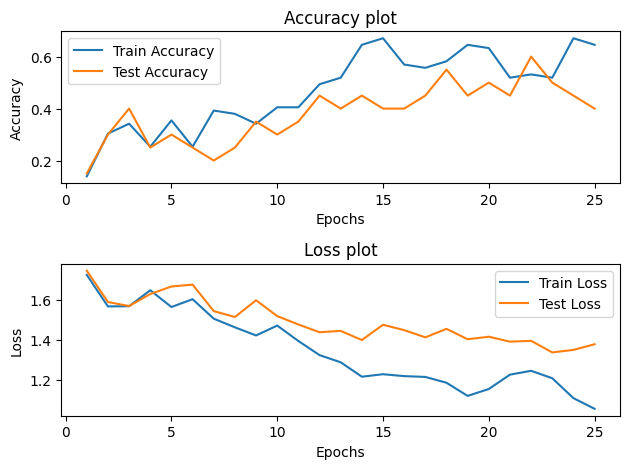

In [50]:
train_acc = output_dict['train_acc']
test_acc = output_dict['test_acc']
train_loss = output_dict['train_loss']
test_loss = output_dict['test_loss']
epochs = range(1, len(train_acc) + 1)

plt.subplot(2, 1, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.legend()

plt.tight_layout()
plt.show()